In [1]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import plotly.io as pio
import sigpy
sys.path.append('../../../src/')

# custom scripts
import mri_cs
from undersampling import radial_sampling
from helpers import calculate_metrics, get_proportion, zero_fill

from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

layout = go.Layout(template="plotly_dark")
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
py.init_notebook_mode()

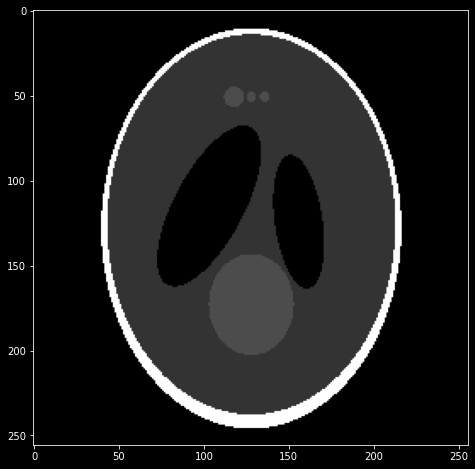

In [2]:
phantom = sigpy.shepp_logan((256, 256))
rows, cols = phantom.shape
_ = plt.imshow(np.abs(phantom), cmap="gray")

0.0791168212890625

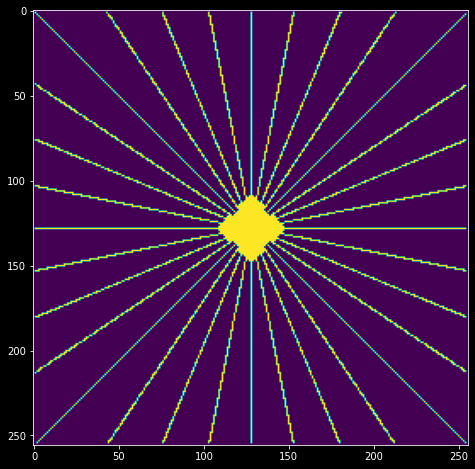

In [3]:
radial_mask = np.fft.fftshift(radial_sampling(rows, cols, 32, dilations=0))
samples_rows = np.where(radial_mask.flatten())[0]
b = np.fft.fft2(phantom).flatten()[samples_rows]

get_proportion(phantom.flatten(), b)
_ = plt.imshow(np.fft.fftshift(radial_mask))

In [4]:
# from scipy.io import savemat

# phantom = {"phantom": phantom}
# b = {"b": b}
# samples_rows = {"samples_rows": samples_rows}

# savemat("samples_rows.mat", samples_rows)
# savemat("b.mat", b)
# savemat("phantom.mat", phantom)

PSNR: 18.721172651106553
SSIM: 0.30438127746616445
SNR: 6.590090835878178
MSE: 0.013424024462264846


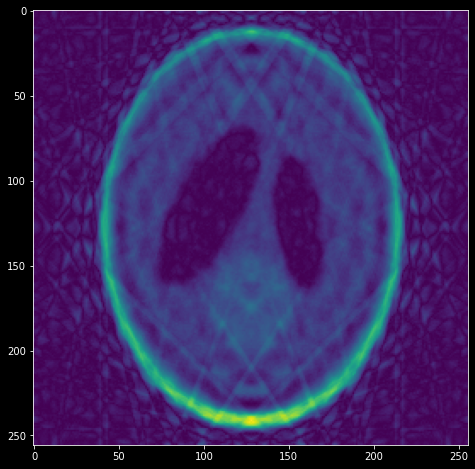

In [5]:
zero_filled = zero_fill(b, samples_rows, rows, cols)

_ = plt.imshow(np.abs(zero_filled))
_ = calculate_metrics(np.abs(phantom), np.abs(zero_filled))

# No prior information LP minimization

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 18.935089111328125s


PSNR: 30.27875378348714
SSIM: 0.8234194401565108
SNR: 18.147671968258766
MSE: 0.0009378310807819102


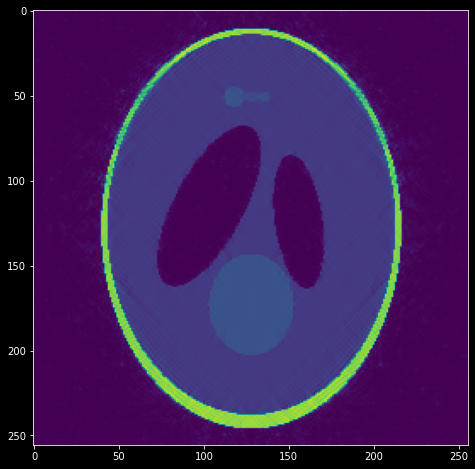

In [6]:
import mri_cs
reload(mri_cs)

filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]
rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30

nopi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 number_jobs=1, maxiterperstage=maxiterperstage,
                                 verbose=False)

plt.imshow(np.abs(nopi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(nopi_recon))

# Extract prior information from fully sampled for the sake of the experiment

[[1.0, -1.0], [1.0, -1.0]]

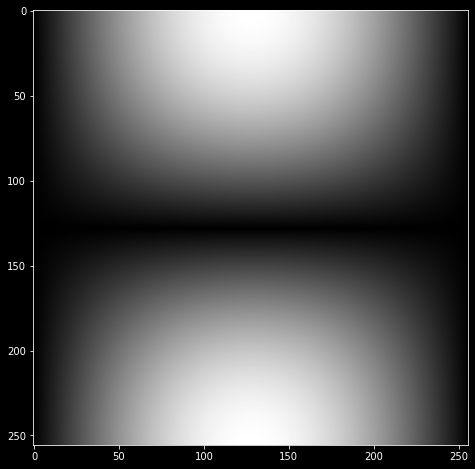

In [26]:
filters[0]
# plt.imshow(filters[0])
plt.imshow(np.abs([np.fft.fft2(np.array(f), (rows, cols)) for f in filters][0]), cmap="gray")

In [29]:
def prior_information(img: np.ndarray, pi_prop: float, filters: list) -> np.ndarray:
    filtered_imgs = []
    rows, cols = img.shape
    # the percentage of highest elements indices to return    
    pi_prop = int(pi_prop * img.size)

    # FFT2 filters and upscale to match image (rows, cols) shape    
    filters_hat = [np.fft.fft2(np.array(f), (rows, cols)) for f in filters]

    assert filters_hat[0].shape == img.shape
    
    img_hat = np.fft.fft2(img)

    # filter x image element wise multiplication    
    for f in filters_hat:
        Xf = img_hat * f
        Xf = np.abs(np.fft.ifft2(Xf))
        filtered_imgs.append(Xf)

    # sort values in descending order and return indices and take only the top pi_prop % values    
    filtered_imgs = [np.argsort(f_img.flatten())[::-1][:pi_prop] for f_img in filtered_imgs]

    # return top threshold % indices
    return filtered_imgs

phi = prior_information(np.abs(phantom), pi_prop=3.5/100, filters=filters)
phi

[array([52798, 43822, 26070, ..., 48082, 31673, 60069]),
 array([62575, 61282, 61089, ..., 60330, 46688, 52453]),
 array([58798, 44078, 61025, ..., 34655, 62262, 39769])]

In [34]:
from scipy.io import savemat

savemat("phi.mat", {"phi": phi})

# LP Minimization with pre filtering and prior information

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 26.90594458580017s
PSNR: 38.945620345235334
SSIM: 0.9289007000596009
SNR: 26.814538530006956
MSE: 0.00012747879965150947


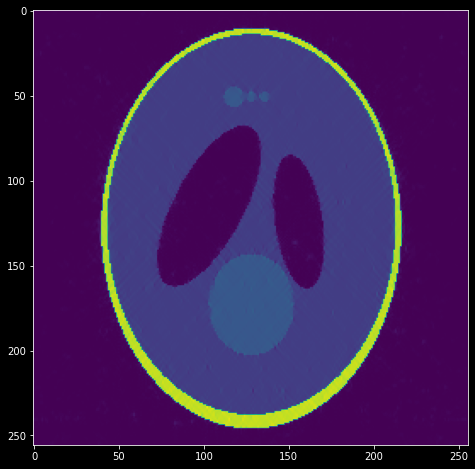

In [30]:
import mri_cs
reload(mri_cs)

rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30
tau = 1e-1

pi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                               p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                               number_jobs=1, maxiterperstage=maxiterperstage,
                               phi=phi, tau=tau, verbose=False)

_ = plt.imshow(np.abs(pi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(pi_recon))